In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## defining all the distances ##

def euclidean_distance(a, b):
    """Return the array of distances of two numpy arrays of points."""

    distance = np.sqrt(((a[0])-b[0])**2 + (a[1]-b[1])**2)

    return distance

def select_closest(candidates, origin):
    """Return the index of the closest candidate to a given point."""

    distance_list = []
    for i in candidates:
      distance_list.append(euclidean_distance(i, origin))

    distance_idx = np.argsort(distance_list)
    return distance_idx[0]

def route_distance(points):
    """Return the cost of traversing a route of points in a certain order."""
    distances = euclidean_distance(points, np.roll(points, 1, axis=0))
    return np.sum(distances)


In [ ]:
## generating the data and preprocessing ##

def normalize(points):
    """
    Return the normalized version of a given vector of points.
    For a given array of n-dimensions, normalize each dimension by removing the
    initial offset and normalizing the points in a proportional interval: [0,1]
    on y, maintining the original ratio on x.
    """
    norm = []
    fin = []

    ratio = [float((max(points[0]) - min(points[0])) / (max(points[1]) - min(points[1]))),1]
    #print(ratio)
    ratio = [ra / max(ratio) for ra in ratio]
    #print(ratio)

    for c in points:
      new_subpoints = [(b - min(c)) / (max(c) - min(c)) for b in c]
      norm.append(new_subpoints)

    fin.append([p*ratio[0] for p in norm[0]])
    fin.append([p*ratio[1] for p in norm[1]])
 
    return fin


In [ ]:
# neuron

def distribute_on_square(size):
  """Distribute the points on the boundary of a square"""

  approx = int(size/4)
  remain = size - 3*approx

  left = np.linspace(0,1,approx)
  remainarr = np.linspace(0,1,remain)

  finarr = []
  for i in left:
    finarr.append([0,i])

  for i in left:
    finarr.append([i,1])

  #now reverse the array to go in cyclic order
  left = left[::-1]
  for i in left:
    finarr.append([1,i])

  #now reverse the remainarr to continue going in cyclic order
  remainarr = remainarr[::-1]
  for i in remainarr:
    finarr.append([i,0])

  return np.array(finarr)

  

def generate_network(size):
    """
    Generate a neuron network of a given size.
    Return a vector of two dimensional points in the interval [0,1].
    """
    return np.random.rand(size, 2)

def get_neighborhood(center, radix, domain):
    """Get the range gaussian of given radix around a center index."""

    # Impose an upper bound on the radix to prevent NaN and blocks
    if radix < 1: radix = 1

    # Compute the circular network distance to the center
    deltas = np.absolute(center - np.arange(domain))
    distances = np.minimum(deltas, domain - deltas)

    # Compute Gaussian distribution around the given center
    return np.exp(-(distances*distances) / (2*(radix*radix)))

def get_route(points, network):
    """Return the route computed by a network."""

    newpoints = []
    for i in range(len(points[0])):
      temp = [points[0][i], points[1][i]]
      newpoints.append(temp)

    winnerlist = []
    
    for j in newpoints:
      winner = select_closest(network, j)
      winnerlist.append(winner)

    return np.argsort(winnerlist)



In [ ]:
# functions to generate the plots

import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_network(points, neurons, name='diagram.png', ax=None):
    """Plot a graphical representation of the problem"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(points[0], points[1], color='red', s=6)
        axis.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.show()
        plt.close()

    else:
        ax.scatter(points[0], points[1], color='red', s=6)
        ax.plot(neurons[:,0], neurons[:,1], 'r.', ls='-', color='#0063ba', markersize=2)
        return ax

def plot_route(points, route, name='diagram.png', ax=None):
    """Plot a graphical representation of the route obtained"""
    mpl.rcParams['agg.path.chunksize'] = 10000

    if not ax:
        fig = plt.figure(figsize=(5, 5), frameon = False)
        axis = fig.add_axes([0,0,1,1])

        axis.set_aspect('equal', adjustable='datalim')
        plt.axis('off')

        axis.scatter(points[0], points[1], color='red', s=6)

        finpoints=[]
        for coor in points:
          finpoints.append([coor[i] for i in route])

        axis.plot(finpoints[0], finpoints[1], color='green', linewidth=1)

        plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=200)
        plt.show()
        plt.close()

    else:
        axis.scatter(points[0], points[1], color='red', s=6)
        
        finpoints=[]
        for coor in points:
          finpoints.append([coor[i] for i in route])

        axis.plot(finpoints[0], finpoints[1], color='purple', linewidth=1)
        return ax

In [ ]:
# main

def som(points, iterations, learning_rate=0.8):
    """Solve the TSP using a Self-Organizing Map."""

    points = normalize(points)

    n = len(points[0])

    newpoints = []
    for i in range(len(points[0])):
      temp = [points[0][i], points[1][i]]
      newpoints.append(temp)

    # Generate an adequate network of neurons:
    #network = generate_network(n)
    network = distribute_on_square(n)

    print('The starting position :')
    plot_network(points, network)

    print('Network of {} neurons created. Starting the iterations:'.format(n))

    for i in range(iterations):
        if not i % 100:
            print('\t> Iteration {}/{}'.format(i, iterations), end="\r")
        # Choose a random city
        random_idx = np.random.randint(0,n)
        city = newpoints[random_idx]
        winner_idx = select_closest(network, city)
        # Generate a filter that applies changes to the winner's gaussian
        gaussian = get_neighborhood(winner_idx, n//10, network.shape[0])
        # Update the network's weights (closer to the city)
        network += gaussian[:,np.newaxis] * learning_rate * (city - network)
        # Decay the variables
        learning_rate = learning_rate * 0.99997
        n = n * 0.9997

        # Check for plotting interval
        if not i % 100:
            plot_network(points, network, name='diagrams/{:05d}.png'.format(i))

        # Check if any parameter has completely decayed.
        if n < 1:
            print('Radius has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
        if learning_rate < 0.001:
            print('Learning rate has completely decayed, finishing execution',
            'at {} iterations'.format(i))
            break
    else:
        print('Completed {} iterations.'.format(iterations))

    plot_network(points, network, name='diagrams/final.png')

    route = get_route(points, network)
    plot_route(points, route, 'diagrams/route.png')
    return route

The starting position :


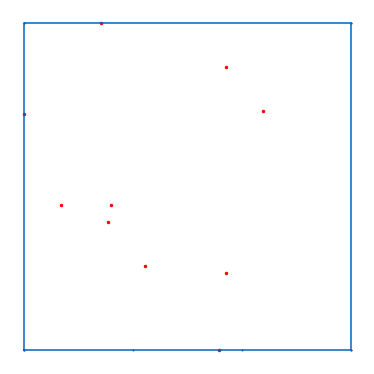

Network of 10 neurons created. Starting the iterations:


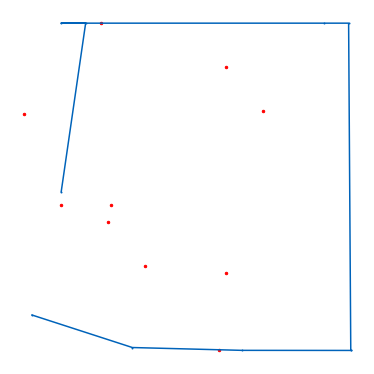

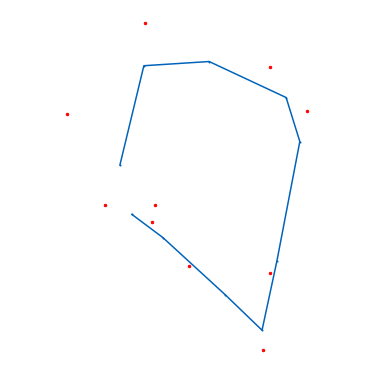

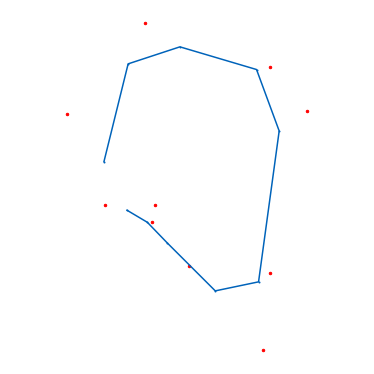

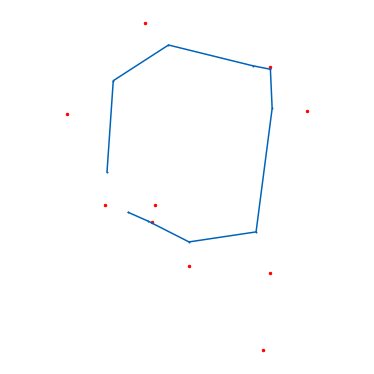

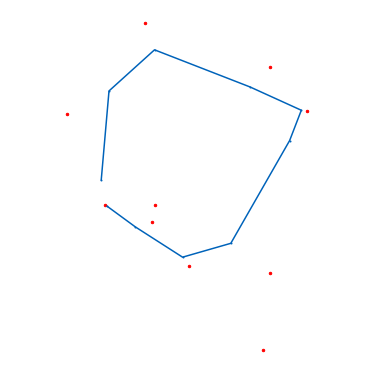

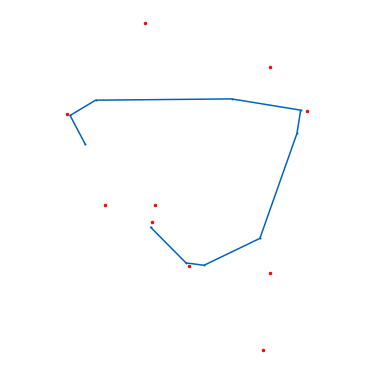

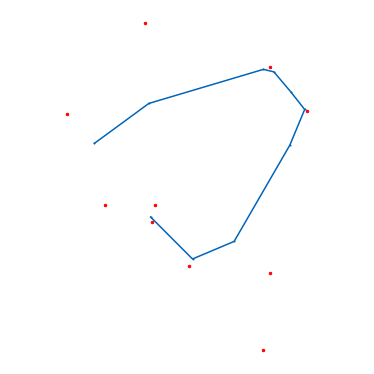

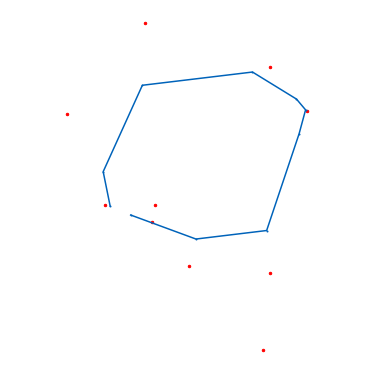

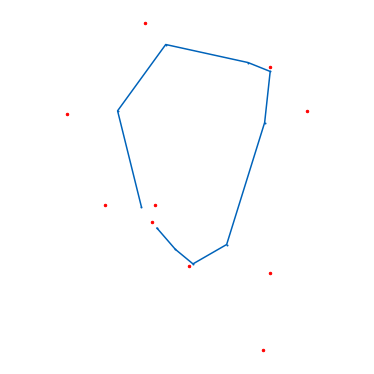

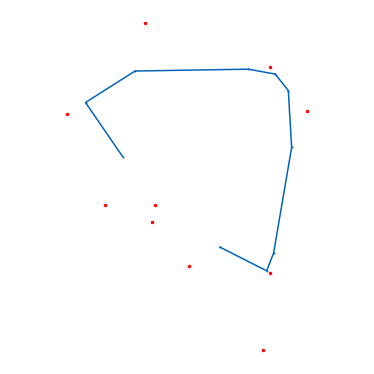

Completed 1000 iterations.


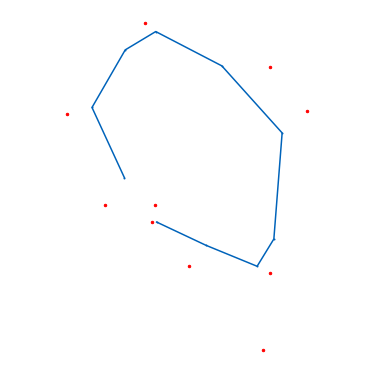

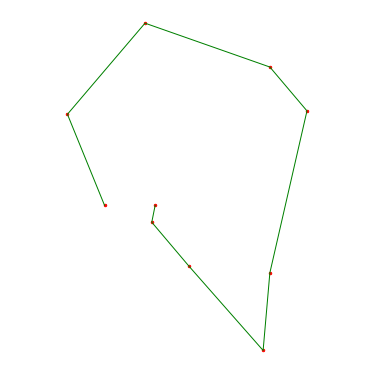

array([7, 1, 0, 4, 5, 6, 8, 3, 2, 9])

In [ ]:
# running the code

#num_points = 10
#points = np.random.randint(0, 100, (2, num_points))

som(points, iterations=1000)

[[ 1 81 12 73 38 79 23 77 95 57]
 [44 93 14 61 25 53 85 90 34 72]]
[1 2 3 4 5 6 7 8 9 0]
[[ 1 81 12 73 38 79 23 77 95 57]
 [44 93 14 61 25 53 85 90 34 72]]


In [ ]:
tot = 25
approx = int(tot/4)
remain = tot - 3*approx

left = np.linspace(0,1,approx)
remainarr = np.linspace(0,1,remain)

finarr = []
for i in left:
  finarr.append([0,i])

for i in left:
  finarr.append([i,1])

#now reverse the array to go in cyclic order
left = left[::-1]
for i in left:
  finarr.append([1,i])

#now reverse the remainarr to continue going in cyclic order
remainarr = remainarr[::-1]
for i in remainarr:
  finarr.append([i,0])

print(finarr, len(finarr))

[[0, 0.0], [0, 0.2], [0, 0.4], [0, 0.6000000000000001], [0, 0.8], [0, 1.0], [0.0, 1], [0.2, 1], [0.4, 1], [0.6000000000000001, 1], [0.8, 1], [1.0, 1], [1, 1.0], [1, 0.8], [1, 0.6000000000000001], [1, 0.4], [1, 0.2], [1, 0.0], [1.0, 0], [0.8333333333333333, 0], [0.6666666666666666, 0], [0.5, 0], [0.3333333333333333, 0], [0.16666666666666666, 0], [0.0, 0]] 25
